Mount google drive to the runtime disk and clone the SYSC4906 repository into google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/MyDrive/SYSC4906/
# !git clone https://github.com/MichaelPatsula/SYSC4906-Project.git
%cd SYSC4906-Project/
!git pull

In [ ]:
#May be needed to get the most recent plotly dependency
%pip install plotly --upgrade pip

**Step #1**: Initialize dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import json
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'colab'

In [2]:
reverse_map = {'Abbotsford': 'Abbotsford, BC',
         'Barrie': 'Barrie, ON',
         'Brampton': "Brampton, ON",
         'Burlington': 'Burlington, ON',
         'Burnaby': 'Burnaby, BC',
         'Calgary': 'Calgary, AB',
         'Coquitlam': 'Coquitlam, BC',
         'Edmonton': 'Edmonton, AB',
         'Fredericton': 'Fredericton, NB',
         'Guelph': 'Guelph, ON',
         'Halifax': 'Halifax, NS',
         'Hamilton': 'Hamilton, ON',
         'Kamloops': 'Kamloops, BC',
         'Kelowna': 'Kelowna, BC',
         'Kingston': 'Kingston, ON',
         'Kitchener': 'Kitchener, ON',
         'Langley, BC': 'Langley, BC',
         'Lethbridge, AB': 'Lethbridge, AB',
         'London':'London, ON',
         'Markham': 'Markham ON',
         'Mississauga': 'Mississauga, ON',
         'Moncton': 'Moncton, NB',
         'Montreal': 'Montreal, QC',
         'Nanaimo, BC': 'Nanaimo, BC',
         'New Westminster': 'New Westminster, BC',
         'North Vancouver': 'North Vancouver, BC',
         'Oakville': 'Oakville, ON',
         'Oshawa': 'Oshawa, ON',
         'Ottawa': 'Ottawa, ON',
         'Quebec City': 'Quebec City, QC',
         'Red Deer': 'Red Deer, AB',
         'Regina': 'Regina, SK',
         'Richmond Hill': 'Richmond Hill, ON',
         "Saint John's": "Saint John's, NL",
         'Saskatoon': 'Saskatoon, SK',
         'St.Catharines': 'St.Catharines, ON',
         'Sudbury': 'Sudbury, ON',
         'Surrey': 'Surrey, BC',
         'Thunder Bay': 'Thunder Bay, ON',
         'Toronto': 'Toronto, ON',
         'Vancouver':'Vancouver, BC',
         'Vaughan': 'Vaughan, ON',
         'Victoria': 'Victoria, BC',
         'Waterloo': 'Waterloo, ON',
         'Windsor': 'Windsor, ON',
         'Winnipeg': 'Winnipeg, MB'
}

**Step #2**: Extract data from .csv and into dataframes

In [5]:
jobs = pd.read_csv("DataSet/JobPostDetails/data.csv")
noc_element = pd.read_csv("DataSet/NOC/noc-cnp-2016-element-v4-eng.csv")
noc_structure = pd.read_csv("DataSet/NOC/noc-cnp-2016-structure-v4-eng.csv")
job_levels = pd.read_csv("DataSet/NOC/JobLevels.csv")

#Create 
numbeo = {}
for dataset in os.listdir("DataSet/Numbeo Data"):
    data = dataset.split(".")[0]
    numbeo[data] = pd.read_csv("DataSet/Numbeo Data/" + dataset)
    numbeo[data].drop("Rank", axis = 1, inplace=True)
    numbeo[data]["City"] = numbeo[data]["City"].apply(lambda x: reverse_map[x])

In [6]:
#Filter the noc_structure to only Unit group and select relevant columns
noc_structure = noc_structure[noc_structure["Hierarchical structure"] == "Unit group"]
noc_structure["Code"] = noc_structure["Code"].astype(np.float64)
noc_structure = noc_structure[["Code", "Class title", "Class definition"]]

#Convert NocNo from job levels to float to merge
job_levels["NocNo"] = job_levels["NocNo"].astype(np.float64)

In [7]:
#Merge the NOC information with jobs
noc_info = pd.merge(noc_structure, job_levels, left_on="Code", right_on="NocNo", how="inner")
noc_info = noc_info.drop("Code", axis=1)

jobs_noc_merged = pd.merge(noc_info, jobs, on="NocNo", how="inner")

In [9]:
#These are the numbeo datasets
numbeo.keys()

dict_keys(['CostofLiving', 'Crime', 'HealthCare', 'PropertyPrices', 'Quality of Life', 'Traffic'])

In [10]:
#numbeo_key = "Traffic"
def merge_numbeo_jobs(onDataset):
  return pd.merge(jobs_noc_merged, numbeo[onDataset], on="City", how="inner")


**Is health correlated to the amount of pollution?**

In [ ]:

method = "spearman"
pd.merge(numbeo["CostofLiving"], numbeo["PropertyPrices"], on="City",  how="inner").corr(method=method)

,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Price To Income Ratio,Gross Rental Yield City Centre,Gross Rental Yield Outside of Centre,Price To Rent Ratio City Centre,Price To Rent Ratio Outside Of City Centre,Mortgage As A Percentage Of Income,Affordability Index
Cost of Living Index,1.000000,0.119911,0.367560,0.785095,0.419355,-0.135929,0.111012,-0.191345,-0.087430,0.191991,0.087430,0.127030,-0.124875
Rent Index,0.119911,1.000000,0.946490,-0.061179,0.106563,-0.065184,0.698776,-0.412059,-0.256507,0.412236,0.256507,0.655172,-0.656205
Cost of Living Plus Rent Index,0.367560,0.946490,1.000000,0.119702,0.232506,-0.056514,0.653688,-0.391633,-0.265881,0.392035,0.265881,0.616754,-0.616875
Groceries Index,0.785095,-0.061179,0.119702,1.000000,0.020245,-0.138598,-0.010901,-0.202247,-0.076752,0.200445,0.076752,0.011791,-0.010017
Restaurant Price Index,0.419355,0.106563,0.232506,0.020245,1.000000,-0.085206,0.035818,0.083435,0.084316,-0.082091,-0.084316,0.075417,-0.073011
Local Purchasing Power Index,-0.135929,-0.065184,-0.056514,-0.138598,-0.085206,1.000000,-0.365517,-0.017577,-0.142158,0.015795,0.142158,-0.431368,0.431608
Price To Income Ratio,0.111012,0.698776,0.653688,-0.010901,0.035818,-0.365517,1.000000,-0.754700,-0.658287,0.754839,0.658287,0.987097,-0.986533
Gross Rental Yield City Centre,-0.191345,-0.412059,-0.391633,-0.202247,0.083435,-0.017577,-0.754700,1.000000,0.701969,-0.999889,-0.701969,-0.726888,0.728406
Gross Rental Yield Outside of Centre,-0.087430,-0.256507,-0.265881,-0.076752,0.084316,-0.142158,-0.658287,0.701969,1.000000,-0.701446,-1.000000,-0.627141,0.625487
Price To Rent Ratio City Centre,0.191991,0.412236,0.392035,0.200445,-0.082091,0.015795,0.754839,-0.999889,-0.701446,1.000000,0.701446,0.727253,-0.728770


**What industry is hiring the most?** 

In [ ]:
#What industry is hiring the most? Top 100
n = 100
jobs_noc_merged["Class title"].value_counts()[:n]

Cooks                                                      2896
Food service supervisors                                   2218
Retail salespersons                                        2212
Transport truck drivers                                    1730
Other customer and information services representatives    1371
                                                           ... 
User support technicians                                    148
Mechanical engineers                                        147
Human resources and recruitment officers                    146
Graphic designers and illustrators                          143
Other administrative services managers                      142
Name: Class title, Length: 100, dtype: int64

The results above show the industries/job types that are currently hiring the most. 
As shown, Cooks, Food service supervisors, Retail salespersons, and truck drivers currently have the most job postings on Canada's Job Bank. 

**What cities have the highest pay and the lowest housing prices?** 

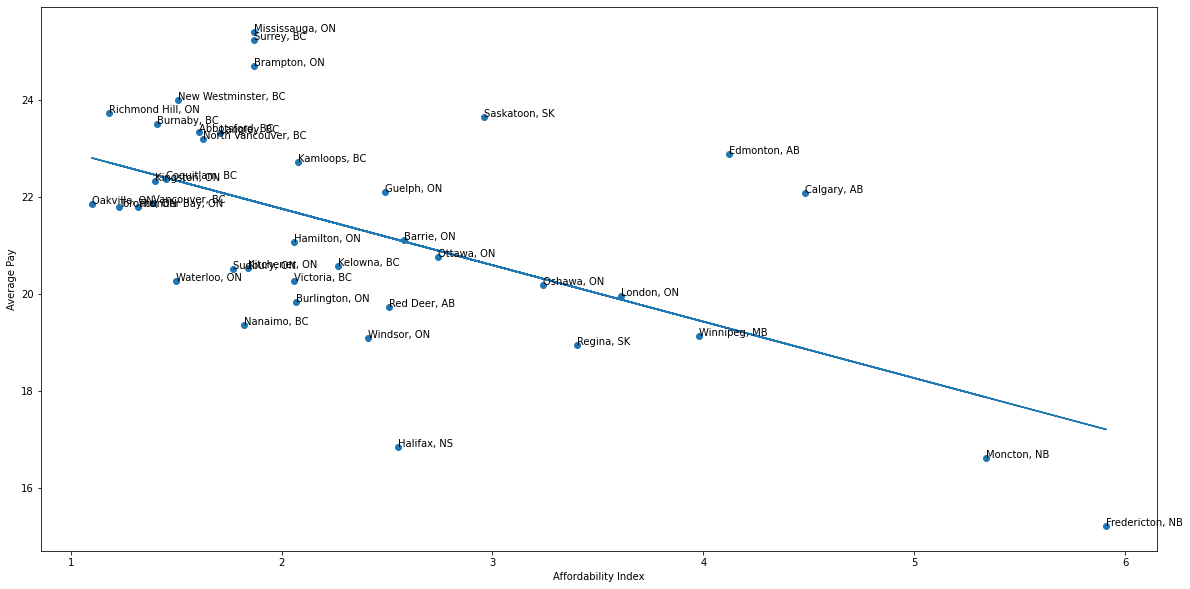

In [ ]:
#Cities with highest pay and lowest housing prices (Best places to move)?
#Consider only hourly
pay_property_merged = merge_numbeo_jobs("PropertyPrices")

pay_property_merged = pay_property_merged[pay_property_merged["PayUnit"] == "HOUR"]
city_pay = {"City":[], "Average Pay":[]}
for city, group in pay_property_merged.groupby("City"):
    group["MinPay"] = group["MinPay"].astype(np.float64)
    city_pay["City"].append(city)
    city_pay["Average Pay"].append(group["MinPay"].mean())
city_pay = pd.DataFrame(city_pay)
answer_dataframe = pd.merge(city_pay, numbeo["PropertyPrices"], on="City", how="inner")

independent_column = "Affordability Index"
dependent_column = "Average Pay"

#Visualize
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(answer_dataframe[independent_column], answer_dataframe[dependent_column])
ax.set_xlabel(independent_column)
ax.set_ylabel(dependent_column)

#Add labels
for i, txt in enumerate(answer_dataframe["City"]):
    ax.annotate(txt, (answer_dataframe[independent_column][i], answer_dataframe[dependent_column][i]))

#Line of best fit
m, b = np.polyfit(answer_dataframe[independent_column], answer_dataframe[dependent_column], 1)
ax.plot(answer_dataframe[independent_column], m*answer_dataframe[independent_column]+b)

The data shows that there is a correlation between the average pay and the affordability of a property. When the affordability  is low, the average page is generally higher which makes sense. As the affordability index increases (becomes more affordable), the average pay tends to decrease. 

It would seem that Edmonton and Calgary are the ideal locations to work in, given the high affordability index, as well as the average pay being higher than usual.  

In [ ]:
#Visualize
def graphScatter(independent_column, dependent_column, answer_dataframe):
  fig, ax = plt.subplots(figsize=(20, 10))
  ax.scatter(answer_dataframe[independent_column], answer_dataframe[dependent_column])
  ax.set_xlabel(independent_column)
  ax.set_ylabel(dependent_column)

def graphBar(independent_column, dependent_column, answer_dataframe):
  fig, ax = plt.subplots(figsize=(20, 10))
  ax.bar(answer_dataframe[independent_column], answer_dataframe[dependent_column], rot=1)
  ax.set_xlabel(independent_column)
  ax.set_ylabel(dependent_column)

def graphMultipleBars(independent_columns, dependent_column, answer_dataframe):
  fig, ax = plt.subplots(figsize=(20, 10))
  
  for index in range(len(independent_columns)):
   ax.bar(answer_dataframe[dependent_column],answer_dataframe[independent_columns[index]])

**Is there more high skill jobs in certain parts of the countries than the other parts and if so where?**

In [ ]:

cleanedJobLevel = []
for x in jobs_noc_merged['JobLevel']:
  cleanedJobLevel.append(x.strip())

jobs_noc_merged['CleanedJobLevel'] = cleanedJobLevel

#Change city to province
jobs_noc_merged["City"] = jobs_noc_merged["City"].apply(lambda x: x.split(',')[1])
jobs_noc_merged = jobs_noc_merged.rename(columns={'City': 'Province'})

city_levelA = {"Province":[], "Level A":[]}
grouped = jobs_noc_merged.query("CleanedJobLevel == 'A'").groupby("Province")
for province, group in grouped:
  city_levelA['Province'].append(province)
  city_levelA['Level A'].append(group.count()[1])

city_levelA = pd.DataFrame(city_levelA)

city_levelB = {"Province":[], "Level B":[]}
grouped = jobs_noc_merged.query("CleanedJobLevel == 'B'").groupby("Province")
for province, group in grouped:
  city_levelB['Province'].append(province)
  city_levelB['Level B'].append(group.count()[1])

city_levelB = pd.DataFrame(city_levelB)

city_levelC = {"Province":[], "Level C":[]}
grouped = jobs_noc_merged.query("CleanedJobLevel == 'C'").groupby("Province")
for province, group in grouped:
  city_levelC['Province'].append(province)
  city_levelC['Level C'].append(group.count()[1])

city_levelC = pd.DataFrame(city_levelC)

city_levelD = {"Province":[], "Level D":[]}
grouped = jobs_noc_merged.query("CleanedJobLevel == 'D'").groupby("Province")
for province, group in grouped:
  city_levelD['Province'].append(province)
  city_levelD['Level D'].append(group.count()[1])

city_levelD = pd.DataFrame(city_levelD)

city_level0 = {"Province":[], "Level 0":[]}
grouped = jobs_noc_merged.query("CleanedJobLevel == '0'").groupby("Province")
for province, group in grouped:
  city_level0['Province'].append(province)
  city_level0['Level 0'].append(group.count()[1])

city_level0 = pd.DataFrame(city_level0)


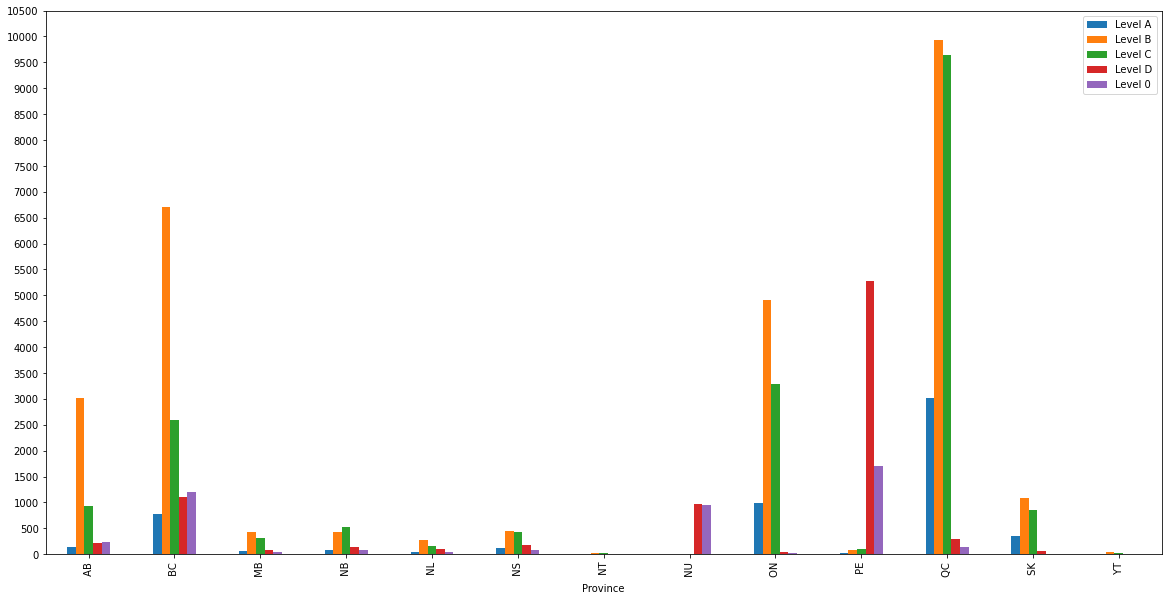

In [ ]:
result = pd.concat([city_level0, city_levelD, city_levelB, city_levelA], axis=1)
result.drop(result.columns[2], axis=1, inplace=True)
result = pd.concat([city_levelC, result], axis=1)
result = result.fillna(0)
result.plot(x="Province", y=["Level A", "Level B", "Level C","Level D","Level 0"], kind="bar",figsize=(20,10), yticks=(np.arange(0,11000,step=500)))


**Is there more high skill jobs in certain parts of the countries than the other parts and if so where?**

The derived data showcases the breakdown of jobs in a province based on skill level. From this data, we can see that depending on the province, the number of total jobs posted is disproportionate. Due to this, simply comparing the number of high skill jobs between provinces would become meaningless as there is a clear bias. This bias may be attributed to a variety of factors which may include population, industry, and available government resources (the Open job board is funded by the government) to name a few. The afore mentioned may be contributing factors, as the data shows that provinces with major metropolitan hubs such as Ontario, Quebec, British Columbia and Alberta have considerably more job postings in comparison to smaller provinces such as those in the maritime region.

Though this data does not provide clear insight on the original problem of interest, it does provide a means to determine which provinces are ideal for individuals looking for jobs of a specific skill level. By analyzing the proportion of high skilled jobs in contrast to other jobs within each province, we can derive insights on which provence provides greater opportunities for a given type of job. For example, provinces such as British Columbia and Alberta seem to employ a larger proportion of individuals in the skills and trades industries in comparison to many other provinces. As such, if an individual who is a trained tradesman, moving to Alberta or British Columbia may be more lucrative as there is a higher proportion of jobs in their skill range in contrast to that of a province such as New Brunswick. By determining these proportions, we can better understand the type of industries currently in demand and the type of jobs that have the most openings.

**What provinces has the highest paying jobs per hour?**


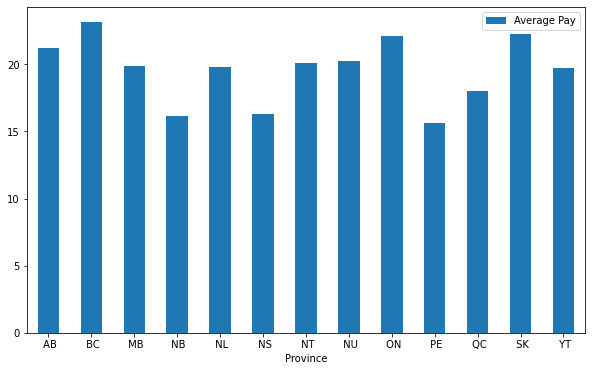

In [16]:
jobs_noc_merged = pd.merge(noc_info, jobs, on="NocNo", how="inner")

#Consider only hourly pay
df = jobs_noc_merged[jobs_noc_merged['PayUnit'] == 'HOUR']

# Remove pays with ',' (e.g. 40,000)
jobs_paid_hourly_cleaned = df.drop(df[df.MinPay.str.contains(',')].index)
#Change city to province
jobs_paid_hourly_cleaned["City"] = jobs_paid_hourly_cleaned["City"].apply(lambda x: x.split(',')[1])
jobs_paid_hourly_cleaned = jobs_paid_hourly_cleaned.rename(columns={'City': 'Province'})

province_pay = {"Province":[], "Average Pay":[]}
for province, group in jobs_paid_hourly_cleaned.groupby("Province"):
    group["MinPay"] = group["MinPay"].astype(np.float64)
    province_pay["Province"].append(province)
    province_pay["Average Pay"].append(group["MinPay"].mean())
province_pay = pd.DataFrame(province_pay)

independent_column = "Province"
dependent_column = "Average Pay"

#Visualize
ax = province_pay.plot.bar(x='Province', y='Average Pay', rot=0, figsize=(10,6)) #rot is for rotation of labels 

As shown from the data, British Columbia appears to have on average the highest paying jobs per hour, followed by Ontario and Saskatechewan. It is important to note that only the minimum pay was considered.   

The below code aggregates the average pay for each province with the quality of life data from Numbeo to create a choropleth map of Canada. When hovering over the provinces of Canada a pop-up box will be displayed containing the quality of life statstics for the respective province, its computed average pay and the number of jobs found within the job board for the province. 

In [8]:
canada = json.load(open("DataSet/Canada/canada_provinces.geojson", "r"))

province_reverse_map = {'Abbotsford': 'Abbotsford, BC',
         'Newfoundland and Labrador': 'NL',
         'Prince Edward Island': 'PE',
         'Nova Scotia': 'NS',
         'New Brunswick': 'NB',
         'Quebec': 'QC',
         'Ontario': 'ON',
         'Manitoba': 'MB',
         'Saskatchewan': 'SK',
         'Alberta': 'AB',
         'British Columbia': 'BC',
         'Yukon': 'YT',
         'Northwest Territories': 'NT',
         'Nunavut': 'NU'
}

#Clean and preprocess data
jobs_noc_merged = pd.merge(noc_info, jobs, on="NocNo", how="inner")
numbeo_key = "Quality of Life"
quality_of_life_merged = pd.merge(jobs_noc_merged, numbeo[numbeo_key], on="City", how="left")
quality_of_life_merged = quality_of_life_merged[quality_of_life_merged['PayUnit'] == 'HOUR']
quality_of_life_merged = quality_of_life_merged.drop(quality_of_life_merged[quality_of_life_merged.MinPay.str.contains(',')].index)
quality_of_life_merged["City"] = quality_of_life_merged["City"].apply(lambda x: x.split(',')[1].strip())
quality_of_life_merged = quality_of_life_merged.rename(columns={'City': 'Province'})

summary_stats = {"Province":[],
                 "Average Pay":[],
                 "Quality of Life Index":[],
                 'Purchasing Power Index':[],
                 'Health Care Index':[],
                 'Cost of Living Index':[],
                 'Property Price to Income Ratio':[],
                 'Traffic Commute Time Index':[],
                 'Pollution Index':[],
                 'Climate Index':[],
                 'Number of Jobs':[]
                }

#Create dictionary containing the mean values of the KPIs in the summary_stats dict
for province, group in quality_of_life_merged.groupby("Province"):
    group["MinPay"] = group["MinPay"].astype(np.float64)
    summary_stats["Province"].append(province)
    summary_stats["Average Pay"].append(group["MinPay"].mean())
    summary_stats['Quality of Life Index'].append(group['Quality of Life Index'].mean())
    summary_stats['Purchasing Power Index'].append(group['Purchasing Power Index'].mean())
    summary_stats['Health Care Index'].append(group['Health Care Index'].mean())
    summary_stats['Cost of Living Index'].append(group['Cost of Living Index'].mean())
    summary_stats['Property Price to Income Ratio'].append(group['Property Price to Income Ratio'].mean())
    summary_stats['Traffic Commute Time Index'].append(group['Traffic Commute Time Index'].mean())
    summary_stats['Climate Index'].append(group['Climate Index'].mean())
    summary_stats['Pollution Index'].append(group['Pollution Index'].mean())
summary_stats['Number of Jobs'] = quality_of_life_merged.groupby('Province').count()['MinPay'].tolist()

summary_stats = pd.DataFrame(summary_stats)

#From the canada dataset extract an id and province name for each province and insert it into a dict
provience_id_map_before = {}
for feature in canada['features']:
  feature['id'] = feature['properties']['cartodb_id']
  provience_id_map_before[feature['properties']['name']] = feature['id']

#Replace the province name in the provience_id_map_before dict with the abbreviated province name
provience_id_map = {}
for province, abbrev in provience_id_map_before.items():
  provience_id_map[province_reverse_map[province]] = provience_id_map_before[province]

#Add each key as a column in the summary_Stats dataframe
summary_stats['Province'] = summary_stats['Province'].str.strip()
summary_stats["id"] = summary_stats["Province"].apply(lambda x: provience_id_map[x])
summary_stats.fillna("None", inplace = True)

#Create choropleth graph of canada
fig = px.choropleth(
    summary_stats,
    locations="id",
    geojson=canada,
    color="Average Pay",
    hover_name="Province",
    hover_data=['Quality of Life Index','Purchasing Power Index',
                'Health Care Index','Cost of Living Index',
                'Property Price to Income Ratio',
                'Traffic Commute Time Index',
                'Climate Index',
                'Pollution Index',
                'Number of Jobs'],
    title="The Average Pay Per Hour Across Canadian Provinces",
)
fig.update_geos(fitbounds="locations", visible=False)
fig.show(renderer='colab')

summary_stats

,Province,Average Pay,Quality of Life Index,Purchasing Power Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index,Number of Jobs,id
0,AB,21.212699,171.553,108.373,77.7539,72.5369,3.59039,29.7987,27.268,32.4995,4117,4
1,BC,23.132049,176.881,91.2731,74.5771,72.3696,9.80641,34.7804,22.4147,87.1158,10369,6
2,MB,19.855971,142.94,92.76,69.06,70.49,3.76,31.47,37.46,24.67,752,10
3,NB,16.118238,None,None,None,None,None,None,None,None,738,7
4,NL,19.762331,None,None,None,None,None,None,None,None,429,5
5,NS,16.279091,166.08,81.83,70.23,74.48,5.7,30.8,23.12,58.99,803,2
6,NT,20.090250,None,None,None,None,None,None,None,None,40,13
7,NU,20.222000,None,None,None,None,None,None,None,None,5,12
8,ON,22.100110,157.62,86.7904,73.1065,72.2958,8.66275,39.0064,30.2795,58.9706,8270,11
9,PE,15.635374,None,None,None,None,None,None,None,None,214,8


**Do cities with higher quality of life also have higher job pay?**


In [ ]:
numbeo_key = "Quality of Life"
quality_of_life_merged = pd.merge(jobs_noc_merged, numbeo[numbeo_key], on="City", how="inner")

quality_of_life_merged = quality_of_life_merged[quality_of_life_merged["PayUnit"] == "HOUR"]
city_pay = {"City":[], "Average Pay":[]}
for city, group in quality_of_life_merged.groupby("City"):
    group["MinPay"] = group["MinPay"].astype(np.float64)
    city_pay["City"].append(city)
    city_pay["Average Pay"].append(group["MinPay"].mean())
city_pay = pd.DataFrame(city_pay)
qol_answer_dataframe = pd.merge(city_pay, numbeo[numbeo_key], on="City", how="inner")

independent_column = "Quality of Life Index"
dependent_column = "Average Pay"

#Correlation
method = "spearman"
qol_answer_dataframe.corr(method=method)

,Average Pay,Quality of Life Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index
Average Pay,1.000000,0.223776,0.300699,0.258741,0.566434,0.118881,0.139860,0.454545,0.167832,0.090909
Quality of Life Index,0.223776,1.000000,0.447552,0.818182,0.090909,0.482517,-0.097902,-0.314685,-0.783217,0.223776
Purchasing Power Index,0.300699,0.447552,1.000000,0.181818,-0.041958,0.181818,-0.510490,-0.258741,0.048951,-0.482517
Safety Index,0.258741,0.818182,0.181818,1.000000,0.188811,0.699301,0.139860,0.048951,-0.650350,0.356643
Health Care Index,0.566434,0.090909,-0.041958,0.188811,1.000000,0.139860,0.034965,0.209790,0.181818,0.342657
Cost of Living Index,0.118881,0.482517,0.181818,0.699301,0.139860,1.000000,0.265734,0.335664,-0.188811,0.363636
Property Price to Income Ratio,0.139860,-0.097902,-0.510490,0.139860,0.034965,0.265734,1.000000,0.559441,0.055944,0.818182
Traffic Commute Time Index,0.454545,-0.314685,-0.258741,0.048951,0.209790,0.335664,0.559441,1.000000,0.454545,0.307692
Pollution Index,0.167832,-0.783217,0.048951,-0.650350,0.181818,-0.188811,0.055944,0.454545,1.000000,-0.237762
Climate Index,0.090909,0.223776,-0.482517,0.356643,0.342657,0.363636,0.818182,0.307692,-0.237762,1.000000


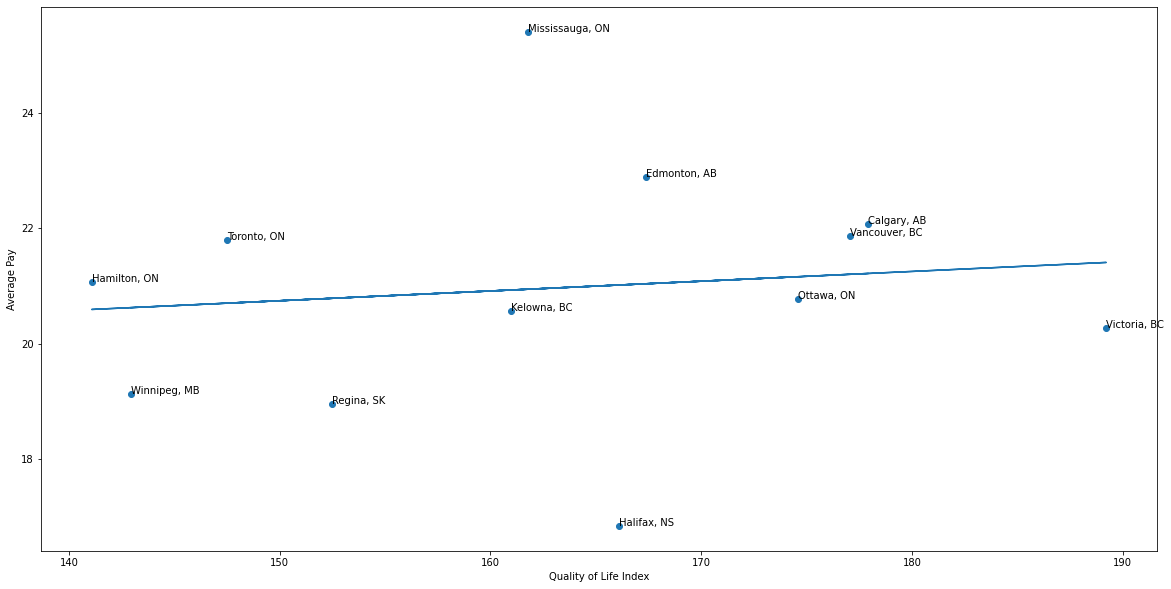

In [ ]:
#Visualize
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(qol_answer_dataframe[independent_column], qol_answer_dataframe[dependent_column])
ax.set_xlabel(independent_column)
ax.set_ylabel(dependent_column)

# #Add labels
for i, txt in enumerate(qol_answer_dataframe["City"]):
    ax.annotate(txt, (qol_answer_dataframe[independent_column][i], qol_answer_dataframe[dependent_column][i]))

# #Line of best fit
m, b = np.polyfit(qol_answer_dataframe[independent_column], qol_answer_dataframe[dependent_column], 1)
ax.plot(qol_answer_dataframe[independent_column], m*qol_answer_dataframe[independent_column]+b)

The data shows that as the quality of life index increases, the average pay will also increase. 

**Are cities with highest paying jobs correlated to pollution**


In [ ]:
numbeo_key = "Traffic"
traffic_merged = pd.merge(jobs_noc_merged, numbeo[numbeo_key], on="City", how="inner")

traffic_merged = traffic_merged[traffic_merged["PayUnit"] == "HOUR"]
city_pay = {"City":[], "Average Pay":[]}
for city, group in traffic_merged.groupby("City"):
    group["MinPay"] = group["MinPay"].astype(np.float64)
    city_pay["City"].append(city)
    city_pay["Average Pay"].append(group["MinPay"].mean())
city_pay = pd.DataFrame(city_pay)
traffic_answer_dataframe = pd.merge(city_pay, numbeo[numbeo_key], on="City", how="inner")

independent_column = "CO2 Emission Index"
dependent_column = "Average Pay"

#Correlation
method = "spearman"
traffic_answer_dataframe.corr(method=method)

,Average Pay,Traffic Index,Time Index(in minutes),Time Exp. Index,Inefficiency Index,CO2 Emission Index
Average Pay,1.000000,0.657343,0.454545,0.454545,0.580420,0.741259
Traffic Index,0.657343,1.000000,0.909091,0.909091,0.741259,0.846154
Time Index(in minutes),0.454545,0.909091,1.000000,1.000000,0.629371,0.622378
Time Exp. Index,0.454545,0.909091,1.000000,1.000000,0.629371,0.622378
Inefficiency Index,0.580420,0.741259,0.629371,0.629371,1.000000,0.594406
CO2 Emission Index,0.741259,0.846154,0.622378,0.622378,0.594406,1.000000


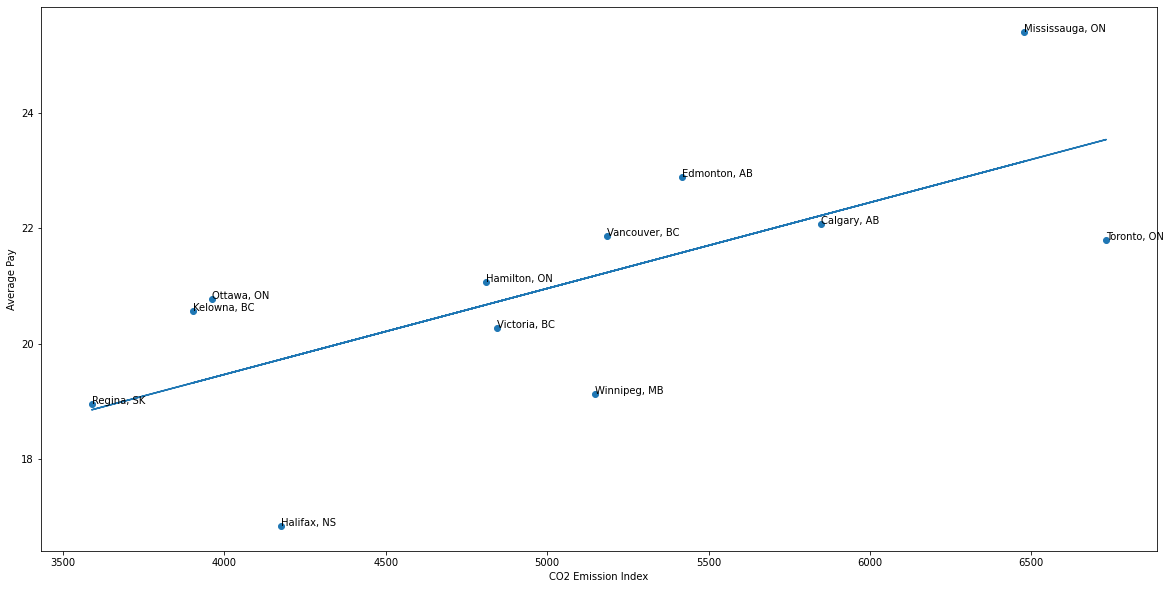

In [ ]:
#Visualize
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(traffic_answer_dataframe[independent_column], traffic_answer_dataframe[dependent_column])
ax.set_xlabel(independent_column)
ax.set_ylabel(dependent_column)

#Add labels
for i, txt in enumerate(traffic_answer_dataframe["City"]):
    ax.annotate(txt, (traffic_answer_dataframe[independent_column][i], traffic_answer_dataframe[dependent_column][i]))

#Line of best fit
m, b = np.polyfit(traffic_answer_dataframe[independent_column], traffic_answer_dataframe[dependent_column], 1)
ax.plot(traffic_answer_dataframe[independent_column], m*traffic_answer_dataframe[independent_column]+b)

According to the data, yes there is a correlation between high paying jobs and pollution. The general trend is that the higher the CO2 emission index, the higher the average pay. This makes sense because generally there is usually more CO2 emissions in urbanized areas, which means there is usually more jobs available and thus a higher paying average. 


**Are high paying jobs correlated with high skills jobs and vice versa?**

In [ ]:
#Clean the pay columns
def isNaN(string):
    return string != string

#Consider only hourly pay
jobs_paid_cleaned = jobs_noc_merged.query('PayUnit == "HOUR"')

jobs_paid_cleaned = jobs_paid_cleaned.drop(jobs_paid_cleaned[jobs_paid_cleaned.MinPay.str.contains(',')].index)
jobs_paid_cleaned = jobs_paid_cleaned[~(isNaN(jobs_paid_cleaned.MaxPay))]
jobs_paid_cleaned = jobs_paid_cleaned.drop(jobs_paid_cleaned[jobs_paid_cleaned.MaxPay.str.contains(',')].index)
#jobs_paid_cleaned = jobs_paid_cleaned['MaxPay'].astype(np.float64)

pay = []
for index, row in jobs_paid_cleaned.iterrows():
    if(isNaN(row['MaxPay'])):
      pay.append(row['MinPay'])
    else:
      avg = float((float(row['MinPay']) + float(row['MaxPay']))/2)
      pay.append(avg)

#Add the pay column to the dataframe
jobs_paid_cleaned['Pay'] = pay
#jobs_paid_cleaned

In [ ]:
jobs_paid_cleaned.groupby("JobLevel").Pay.mean()

JobLevel
 0    29.216672
 A    35.392947
 B    23.461909
 C    19.024909
 D    18.211005
Name: Pay, dtype: float64

According to the data, yes there is a correlation between high paying jovs and high skill jobs. 
As shown, the higher the skill level of a job, the higher the pay. 

**Are most jobs on the Job board low skill or high skill jobs?**

In [ ]:
jobs_noc_merged["JobLevel"].value_counts()

 B    27386
 C    18874
 D     8464
 A     5632
 0     4519
Name: JobLevel, dtype: int64

**Do jobs with higher skill level have higher traffic?**

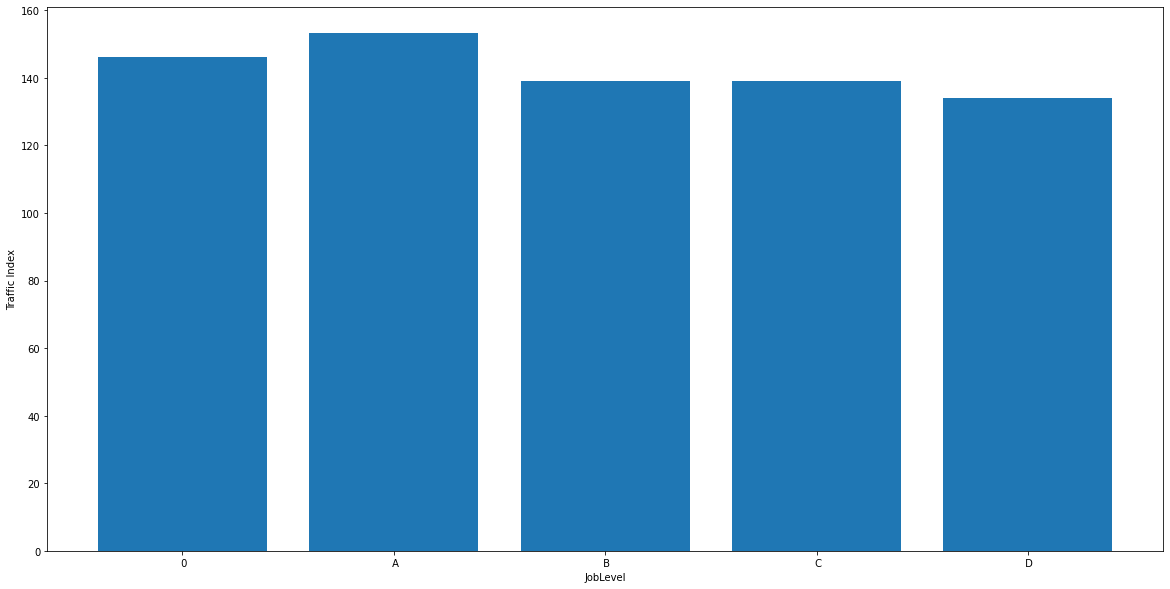

In [ ]:
jobs_noc_merged = pd.merge(noc_info, jobs, on="NocNo", how="inner")
traffic_jobs_df = merge_numbeo_jobs('Traffic')
result = traffic_jobs_df.groupby("JobLevel", as_index=False).mean()

graphBar('JobLevel', 'Traffic Index', result)

From the data, it seems that for job levels that are management or require a university degree, the traffic index is higher compared to the lower job levels. So it does appear that jobs with higher skill lever have higher traffic. 

**What cities are best for a job industry (For ex: For software developers, what cities should they work in?)**

In [ ]:
# jobs_noc_merged = pd.merge(noc_info, jobs, on="NocNo", how="inner")
# jobs_noc_merged


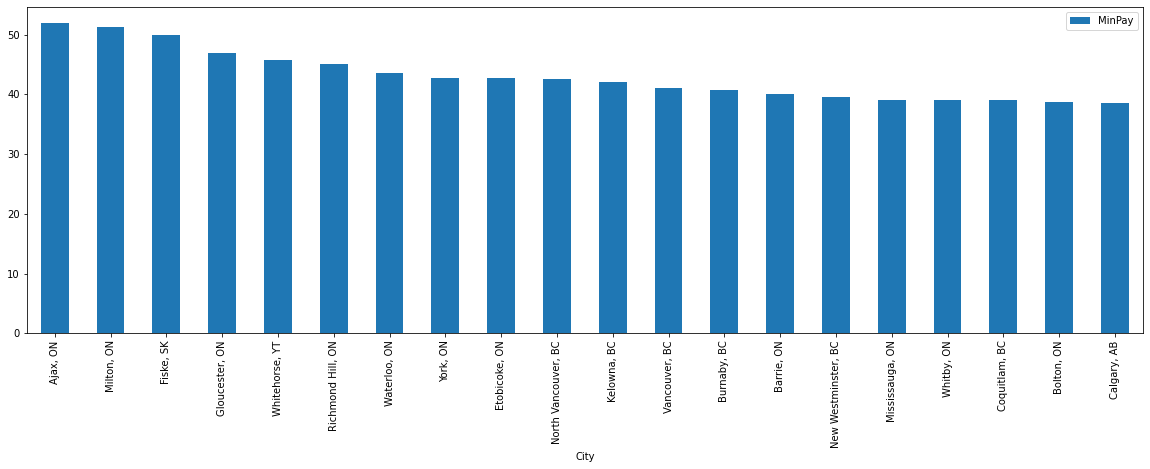

In [ ]:
val = jobs_noc_merged["Job Title"].str.lower().str.contains("|".join(["software", "computer", "information" ]))
# jobs_noc_merged[val]
selected = jobs_noc_merged[val].copy(deep=True)
selected = selected[selected["PayUnit"]=="HOUR"]
selected = selected.drop(selected[selected.MinPay.str.contains(',')].index)
selected["MinPay"]=selected["MinPay"].astype(np.float64)
selected = selected[selected["MinPay"]<80]
selected["City"] = selected["City"].str.strip("based in ")
selected = selected.groupby("City", as_index=False).mean()
selected = selected.sort_values("MinPay", ascending=False)

# selected["MinPay"].max

selected_plot = selected.head(20)
# graphBar("City", "MinPay", selected_plot)
ax = selected_plot.plot.bar(x='City', y='MinPay', figsize=(20,6)) #rot is for rotation of labels 




According to the data, Ajax and Milton in Ontario appear to have job postings for software developers that pay the most. 

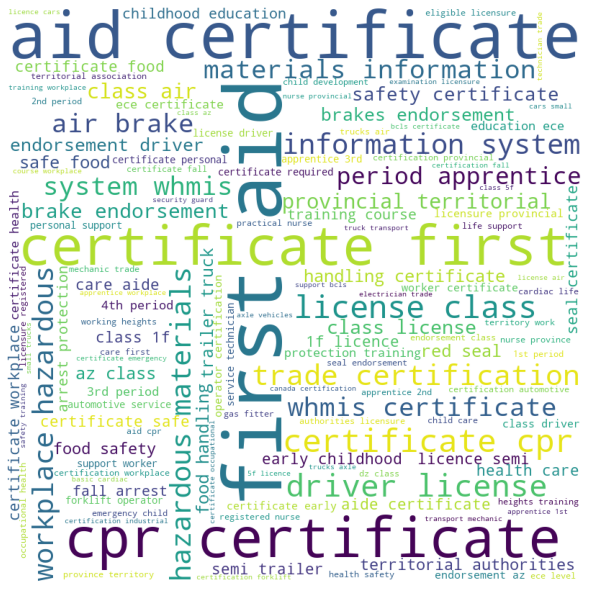

In [ ]:
from wordcloud import WordCloud, STOPWORDS
jobs_noc_merged = pd.merge(noc_info, jobs, on="NocNo", how="inner")
jobs_noc_merged["Job Title"] = jobs_noc_merged["Job Title"].str.strip() 

category = jobs_noc_merged[~jobs_noc_merged["Qualifications"].isnull()]["Qualifications"]
def generateWordCloud(category):
  comment_words = ''
  stopwords = set(STOPWORDS)

  # iterate through the csv file
  for val in category:
      
    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "


  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

  # plot the WordCloud image                       
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

generateWordCloud(jobs_noc_merged[~jobs_noc_merged["Qualifications"].isnull()]["Qualifications"])


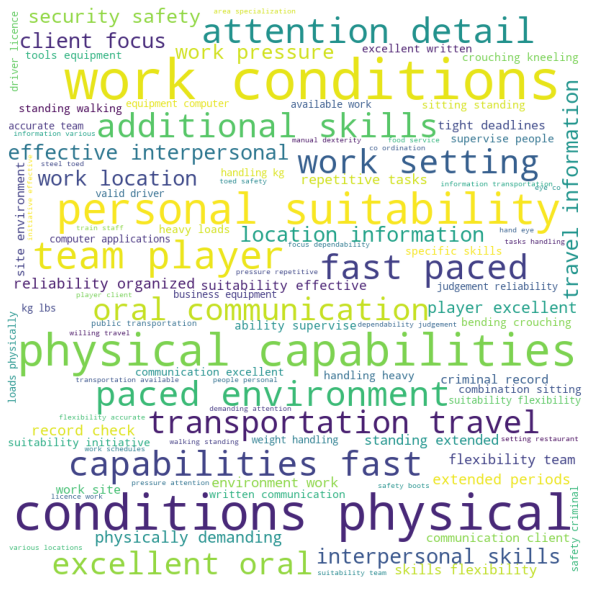

In [ ]:
generateWordCloud(jobs_noc_merged[~jobs_noc_merged["Skills"].isnull()]["Skills"])
